## Set Up

In [ ]:
import pandas as pd
import seaborn as sns
import geopandas as gpd
import geoalchemy2 as gdb
from shapely.wkt import dumps
import shapely
from sqlalchemy import Column, Integer, Float, Text, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.dialects.postgresql import ARRAY
from geoalchemy2 import Geometry
import sqlalchemy as db
from sqlalchemy.orm import declarative_base
import matplotlib.pyplot as plt
from functools import partial
import pyproj
from shapely.ops import transform
from shapely.geometry import Point
from pyproj import CRS
import psycopg2
from shapely.wkt import loads
import json
import requests



## Part 1: Data Preprocessing

In [ ]:
APP_token='e7z7ut3fm3cFgwNa696AMxzFJ'
complaints311_head = ['complaint_type', 'incident_zip', 'created_date', 'latitude', 'longitude']
complaints311__API_endpoint = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json?$select=' + ','.join(complaints311_head) + '&$where=created_date >= "2015-01-01T00:00:00"'
tree_head = ['tree_id', 'latitude', 'longitude', 'health', 'spc_common', 'status', 'zipcode']
tree_census2015_API_endpoint = 'https://data.cityofnewyork.us/resource/5rq2-4hqu.json?$select=' + ','.join(tree_head)
#complaints311__link_url='https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/pi5s-9p35'
#tree_census2015_link_url='https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9'
chunk_size = 1000000

headers = {'X-App-Token': APP_token}

def fetch_data1(api_endpoint):
    """fetch data chunk by chunk from api_endpoint and save each chunk of data as local json files"""
    offset = 0
    data_311_chunk_count=0
    while True:
        i=data_311_chunk_count
        params = {'$limit': chunk_size, '$offset': offset}
        response = requests.get(api_endpoint, headers=headers, params=params)
        if not response.ok:
            break  
        records = response.json()
        if response.ok:
            data = response.json()

            with open(f'data_311_chunk_{i}.json', 'w') as file:
                json.dump(data, file, indent=2)
        if not records:
            break  
        offset += chunk_size
        data_311_chunk_count+=1
        print(data_311_chunk_count)
        


In [ ]:
nyc_zipcodes_data = gpd.read_file('data/nyc_zipcodes/nyc_zipcodes.shp')
zillow_rent_data = pd.read_csv('data/zillow_rent_data.csv')

##### Below is the code to move nyc_zipcodes and zillow_rent_data.csv downloaded into data direction

In [ ]:
!mkdir data
!mv nyc_zipcodes data/
!mv zillow_rent_data.csv data/

###### The code below is to save complaints311 as multiple file in the local computer

In [ ]:
fetch_data1(complaints311__API_endpoint)

In [ ]:
#import those json files'names into file_list
file_list=[f"data_311_chunk_{i}.json" for i in range(26)]
#load each json file as pandas Dataframe and save them into df_list
df_list=[]
for file_name in file_list:
    with open(file_name, 'r') as file:
        data = json.load(file)
        df = pd.DataFrame(data)
        df_list.append(df)

# concate those pandas dataframe inside df_list as combined_df
combined_df = pd.concat(df_list, ignore_index=True)
complaints311_data=combined_df


In [ ]:
#create geometry column based on latitude and longitude
geometry1 = []
for index, row in complaints311_data.iterrows():
    if 'longitude' in row and 'latitude' in row:
        longitude = float(row['longitude'])
        latitude = float(row['latitude'])
        point = Point(longitude, latitude)
        geometry1.append(point)
    else:
        geometry1.append(None)

#create the complaints311_data as the geopanda dataframe containing information from 311 complaints
complaints311_data=gpd.GeoDataFrame(complaints311_data,geometry=geometry1,crs="EPSG:4326")

In [ ]:
#Get data from tree_census2015
tree_census2015_data=fetch_data(tree_census2015_API_endpoint)

#create geometry column based on latitude and longitude
geometry2 = []
for row in tree_census2015_data:
    if 'longitude' in row and 'latitude' in row:
        longitude = float(row['longitude'])
        latitude = float(row['latitude'])
        point = Point(longitude, latitude)
        geometry2.append(point)
    else:
        geometry2.append(None)

#create the tree_census2015_data as the geopanda dataframe containing information from 2015 tree census
tree_census2015_data=gpd.GeoDataFrame(tree_census2015_data,geometry=geometry2,crs="EPSG:4326")

In [ ]:
#load Shapefiles of NYC’s zip codes with geometric boundary data 
nyc_zipcodes_data = gpd.read_file('data/nyc_zipcodes/nyc_zipcodes.shp')
#Only keeps two columns (ZIPCODE and geometry), drop the others
head=['STATE','BLDGZIP','COUNTY','CTY_FIPS','URL','PO_NAME','POPULATION','AREA','SHAPE_AREA','SHAPE_LEN','ST_FIPS']
nyc_zipcodes_data=nyc_zipcodes_data.drop(head,axis=1)
# Set the SRID to be 4326
nyc_zipcodes_data.crs = CRS.from_epsg(4326)

In [ ]:
#load Historical monthly average rents by zip code from Zillow
zillow_rent_data = pd.read_csv('data/zillow_rent_data.csv')
zillow_rent_data=zillow_rent_data[zillow_rent_data['City']=='New York']
zillow_rent_data=zillow_rent_data[zillow_rent_data['RegionType']=='zip']
zillow_rent_data=zillow_rent_data[zillow_rent_data['City']=='New York']
#Only keep RegionName and all the rent data from time to time.
drop_head=['RegionID','SizeRank','RegionType','StateName','State','City','Metro','CountyName']
zillow_rent_data=zillow_rent_data.drop(drop_head,axis=1)

## Part 2: Storing Data

In [ ]:
!createdb IEOR_4501_Final_Project

createdb: error: database creation failed: ERROR:  database "IEOR_4501_Final_Project" already exists


In [ ]:
!psql --dbname IEOR_4501_Final_Project -c 'CREATE EXTENSION postgis;'

ERROR:  extension "postgis" already exists


In [ ]:
DB_NAME = "IEOR_4501_Final_Project"
DB_USER = "postgres"
DB_URL = f"postgresql+psycopg2://{DB_USER}@localhost/{DB_NAME}"
DB_SCHEMA_FILE = "schema.sql"
engine = db.create_engine(DB_URL)

In [ ]:
# Create schema
ZIPCODE_SCHEMA = """
CREATE TABLE zipcodes (
    id INTEGER PRIMARY KEY,
    ZIPCODE TEXT,
    geometry GEOMETRY
);
"""

NYC_311_SCHEMA = """
CREATE TABLE complaint311s (
        id INTEGER PRIMARY KEY,
        complaint_type TEXT,
        incident_zip TEXT,
        created_date TEXT,
        latitude REAL,
        longitude REAL,
        geometry GEOMETRY
    );
"""

NYC_TREE_SCHEMA = """
CREATE TABLE trees (
    id INTEGER PRIMARY KEY,
    tree_id INTEGER,
    latitude REAL,
    longitude REAL,
    health TEXT,
    spc_common TEXT,
    status TEXT,
    zipcode TEXT,
    geometry GEOMETRY
);
"""


NYC_RENT_SCHEMA = """
CREATE TABLE nyc_rents (
        id INTEGER PRIMARY KEY,
        regionname TEXT,
        rent real []
    );
"""

In [ ]:
#write schema file
with open(DB_SCHEMA_FILE, "w") as f:
    f.write(ZIPCODE_SCHEMA)
    f.write(NYC_311_SCHEMA)
    f.write(NYC_TREE_SCHEMA)
    f.write(NYC_RENT_SCHEMA)


In [ ]:
Base = declarative_base()


class NYC_Rent(Base):
    """create table named nyc_rents containing regionname and rent as columns"""
    __tablename__ = "nyc_rents"
    id = Column(Integer, primary_key=True)
    regionname = Column(String)
    rent = Column(ARRAY(Float))



In [ ]:
Base.metadata.create_all(engine)
Session = db.orm.sessionmaker(bind=engine)
session = Session()

In [ ]:
#create SQL tables directly from using to_postgis function
tree_census2015_data.to_postgis("trees", engine, index_label="tree_id")
complaints311_data.to_postgis("complaint311s", engine)
nyc_zipcodes_data.to_postgis("zipcodes", engine)

In [ ]:
#add data to the nyc_rents table
for index, row in zillow_rent_data.iterrows():
    NYC_rent = NYC_Rent(
        regionname=row['RegionName'],
        rent=row[1:].tolist()
    )
    session.add(NYC_rent)

In [ ]:
session.commit()

##### A Helper function

In [ ]:
# This is just a helper dictionary used to locate the index needed in nyc_rent.rent 
# for a specific month in a specific year
def Total_time(time):
    """Take a string value in YEAR-month and return the corresponding index in nyc_rent.rent"""
    Total_time_list=dict()
    count=0
    for i in range(2015,2023):
        for j in range(1,10):
            x=f"{i}-0{j}"
            Total_time_list[x]=count
            count+=1
        for j in range(10,13):
            x=f"{i}-{j}"
            Total_time_list[x]=count
            count+=1
    for i in range(1,10):
        x=f"2023-0{i}"
        Total_time_list[x]=count
        count+=1
    return Total_time_list[time]

## Part 3: Understanding data

In [ ]:
#Query 1: Which area might be more calm to live in?
#Between October 1st, 2022 and September 30th, 2023 (inclusive), find the number of 311 complaints per zip code. 
#The query result should have two columns, one row per zip code, with the number of complaints 
#in descending order.

QUERY_1="""
SELECT
    incident_zip,
    COUNT(*) AS number_of_complaints
FROM
    complaint311s
WHERE
    created_date BETWEEN '2022-10-01' AND '2023-09-30'
GROUP BY
    incident_zip
ORDER BY
    number_of_complaints DESC;
"""

In [ ]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_1))
    for row in result:
        print(row)

('11226', 49425)
('10467', 47430)
('10468', 44190)
('11385', 44020)
('10452', 43966)
('10457', 41625)
('10458', 41273)
('11207', 40215)
('10456', 39830)
(None, 39731)
('11201', 39403)
('10453', 38158)
('11208', 36795)
('10031', 33914)
('11221', 33147)
('10466', 32637)
('10032', 32096)
('10025', 31146)
('10462', 30826)
('11238', 30225)
('11230', 29721)
('11368', 29290)
('11220', 29102)
('10019', 28368)
('11216', 28213)
('11225', 28114)
('11235', 27886)
('11212', 27416)
('10463', 27125)
('11203', 27059)
('10460', 27046)
('10023', 26979)
('11214', 26823)
('11377', 26435)
('11101', 26029)
('11213', 25942)
('10027', 25934)
('10002', 25645)
('11234', 25609)
('11211', 25599)
('11206', 25433)
('11209', 25428)
('11215', 25378)
('11222', 25351)
('10472', 25351)
('11218', 25119)
('11233', 25000)
('11223', 24377)
('11373', 24137)
('10033', 23721)
('11237', 23425)
('11229', 22907)
('11236', 22740)
('10461', 22391)
('10034', 22371)
('10011', 22234)
('11204', 21823)
('10003', 21792)
('11210', 21456)


In [ ]:
#Query 2: Where has the most greenery?
#Using just the trees table, which 10 zip codes have the most trees?
#The query result should have two columns, 10 rows. The rows should be sorted by the total number of trees,
#descending.


QUERY_2="""SELECT
    zipcode,
    COUNT(*) AS total_trees
FROM
    trees
GROUP BY
    zipcode
ORDER BY
    total_trees DESC
LIMIT 10;
"""

In [ ]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_2))
    for row in result:
        print(row)

('10312', 22186)
('10314', 16905)
('10306', 13030)
('10309', 12650)
('11234', 11253)
('11385', 10937)
('11357', 9449)
('11207', 8634)
('11434', 8274)
('11208', 8245)


In [ ]:
#Query 3: Can I afford a place in the areas with the most trees?
#Of the 10 zip codes with the most trees, for the month of August 2023, what is the average rent by zip code?
#The query should have a JOIN statement. The query result should have two columns (not three) and 10 rows. 
#The rows should be sorted by the total number of trees, descending. “Humanize” the rent numbers,
#meaning format the results as 2,879.58 instead of 2879.575128. 


QUERY_3="""SELECT
    trees.zipcode,
    TO_CHAR(AVG(CAST(nyc_rents.rent[103] AS NUMERIC)), 'FM9,999.99') AS average_rent
FROM
    trees
JOIN
    nyc_rents
    ON trees.zipcode = CAST(REGEXP_REPLACE(nyc_rents.RegionName, '\.0$', '') AS INTEGER)::VARCHAR
GROUP BY
    trees.zipcode
ORDER BY
   COUNT(trees.tree_id) DESC
LIMIT 10;
"""


In [ ]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_3))
    for row in result:
        print(row)

('10312', '1,709.74')
('10314', '2,467.05')
('10306', '2,330.52')
('10309', '1,733.61')
('11234', '2,292.07')
('11385', '3,034.41')
('11357', '2,417.08')
('11207', '3,011.85')
('11434', '2,744.81')
('11208', '2,765.22')


In [ ]:
#Query 4: Could there be a correlation between an area’s rent, the number of its trees, 
#and the number of 311 complaints? For the month of January 2023, return the 5 zip codes with the 
#lowest average rent, and 5 zipcodes of the highest average rent, and include the tree count 
#and complaint count for each zip code by using JOIN statements.

#The query result should have 4 columns (zip code, average rent, tree count, and complaint count) and 10 rows:
#five with the highest average rent, and five with the lowest average rent. “Humanize” the rent numbers, 
#meaning format the results as 2,879.58 instead of 2879.575128.


QUERY_4="""WITH Rent_per_zip AS (
    SELECT
        CAST(REGEXP_REPLACE(nyc_rents.RegionName, '\.0$', '') AS INTEGER)::VARCHAR AS zipcode,
        AVG(CAST(nyc_rents.rent[96] AS NUMERIC)) AS avg_rent
    FROM
        nyc_rents
    WHERE nyc_rents.rent[96] != 'NaN'
    GROUP BY
        nyc_rents.RegionName
),
Tree_per_zip AS (
    SELECT
        trees.zipcode,
        COUNT(*) AS tree_count
    FROM
        trees
    GROUP BY
        trees.zipcode
),
Complaints_per_zipcode AS (
    SELECT
        complaint311s.incident_zip,
        COUNT(*) AS complaint_count
    FROM
        complaint311s
    WHERE
        complaint311s.created_date BETWEEN '2023-01-01' AND '2023-01-31'
    GROUP BY
        complaint311s.incident_zip
)

SELECT *
FROM (
    SELECT
        Rent_per_zip.zipcode AS zipcode,
        TO_CHAR(Rent_per_zip.avg_rent, 'FM9,999.99') AS avg_rent,
        COALESCE(Tree_per_zip.tree_count, 0) AS tree_count,
        COALESCE(Complaints_per_zipcode.complaint_count, 0) AS complaint_count
    FROM
        Rent_per_zip
    LEFT JOIN
        Tree_per_zip ON Rent_per_zip.zipcode = Tree_per_zip.zipcode
    LEFT JOIN
        Complaints_per_zipcode ON Rent_per_zip.zipcode = Complaints_per_zipcode.incident_zip
    WHERE
        Rent_per_zip.avg_rent IS NOT NULL
    ORDER BY
        Rent_per_zip.avg_rent ASC
    LIMIT 5
) AS lowest_rent

UNION

SELECT *
FROM (
    SELECT
        Rent_per_zip.zipcode,
        TO_CHAR(Rent_per_zip.avg_rent, 'FM9,999.99') AS avg_rent,
        COALESCE(Tree_per_zip.tree_count, 0) AS tree_count,
        COALESCE(Complaints_per_zipcode.complaint_count, 0) AS complaint_count
    FROM
        Rent_per_zip
    LEFT JOIN
        Tree_per_zip ON Rent_per_zip.zipcode = Tree_per_zip.zipcode
    LEFT JOIN
        Complaints_per_zipcode ON Rent_per_zip.zipcode = Complaints_per_zipcode.incident_zip
    WHERE
        Rent_per_zip.avg_rent IS NOT NULL
    ORDER BY
        Rent_per_zip.avg_rent DESC
    LIMIT 5
) AS highest_rent
ORDER BY 2 DESC;
"""



In [ ]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_4))
    for row in result:
        print(row)

('10007', '7,260.46', 355, 250)
('10282', '7,058.61', 234, 39)
('10013', '5,551.23', 1202, 740)
('10069', '5,003.4', 119, 35)
('10011', '4,789.54', 2134, 1486)
('11357', '1,788.94', 9449, 900)
('10462', '1,776.66', 4234, 2276)
('10453', '1,762.64', 3050, 2941)
('10312', '1,644.01', 22186, 1375)
('10309', '1,456.13', 12650, 800)


In [ ]:
#Query 5: Where has the most greenery (take 2)?
#Rewrite Query 2 to use both the trees table and the zipcodes table. Join both tables where the 
#coordinate point of the tree is inside the polygon boundary of the zipcode as defined in the zipcode table.

#The query should have a JOIN statement. The query results should match exactly the results of Query 2.


QUERY_5="""
SELECT 
    ZIPCODE,
    COUNT(*) AS total_trees
FROM
    trees
JOIN
    zipcodes
ON
    ST_Within(
        trees.geometry,
        ST_Transform(zipcodes.geometry, 4326)
    )
GROUP BY
    ZIPCODE
ORDER BY
    total_trees DESC
LIMIT 10;

"""



In [ ]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_5))
    for row in result:
        print(row)

('10312', 22186)
('10314', 16905)
('10306', 13030)
('10309', 12650)
('11234', 11253)
('11385', 10937)
('11357', 9449)
('11207', 8634)
('11434', 8274)
('11208', 8245)


In [ ]:
#Query 6: What is the immediate area like?
#Using the following coordinate pair on campus, which trees are within ½ mile radius of this point?
#Latitude: 40.80737875669467, Longitude: -73.96253174434912
#The result should have 5 columns (ID, species, health, status, and coordinate location of each tree).
#You may use regular Python to help construct the geometric object needed for setting the radius in the query.







campus_location = Point(-73.96253174434912, 40.80737875669467)
gdf_point = gpd.GeoDataFrame(geometry=[campus_location], crs='EPSG:4326')

#create the buffer radius and buffer area based on the requirement of query 6
buffer_radius = 0.5
buffered_area = gdf_point.buffer(buffer_radius)
buffered_area_wkt = buffered_area.to_wkt()[0]





QUERY_6="""
SELECT
    tree_id,
    spc_common,
    health,
    status,
    ST_AsText(geometry) AS coordinate_location
FROM
    trees
WHERE
    ST_DWithin(
        trees.geometry,
        ST_GeomFromText(:buffered_area_wkt, 4326),
        :buffer_radius * 1609.34  
    );
"""

/var/folders/07/js97l93n0g56kwpk1999d4c80000gn/T/ipykernel_57158/255792664.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_area = gdf_point.buffer(buffer_radius)


In [ ]:
with engine.connect() as conn:
    result = conn.execute(text(QUERY_6), buffered_area_wkt=buffered_area_wkt, buffer_radius=buffer_radius)
    for row in result:
        print(row)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



('558360', 'ginkgo', 'Poor', 'Alive', 'POINT(-73.78908363 40.67586078)')
('548051', 'honeylocust', 'Good', 'Alive', 'POINT(-73.95328002 40.69856236)')
('569811', 'ginkgo', 'Fair', 'Alive', 'POINT(-73.88499901 40.74333142)')
('566901', 'ginkgo', 'Fair', 'Alive', 'POINT(-73.73462064 40.69172409)')
('545558', 'American linden', 'Good', 'Alive', 'POINT(-73.94257644 40.62242901)')
('558494', 'ginkgo', 'Fair', 'Alive', 'POINT(-73.78714252 40.67587693)')
('558596', 'ginkgo', 'Fair', 'Alive', 'POINT(-73.78957833 40.67608617)')
('535068', 'American linden', 'Good', 'Alive', 'POINT(-73.93967912 40.63869314)')
('573122', 'honeylocust', 'Good', 'Alive', 'POINT(-73.73557864 40.6881945)')
('558668', 'ginkgo', 'Fair', 'Alive', 'POINT(-73.78826783 40.67700021)')
('532335', 'honeylocust', 'Good', 'Alive', 'POINT(-74.16088204 40.56100519)')
('560311', 'American linden', 'Good', 'Alive', 'POINT(-73.75439095 40.71038147)')
('554456', 'honeylocust', 'Good', 'Alive', 'POINT(-73.91582439 40.83981752)')
('572

In [ ]:
# a helper function to write query to file
def write_query_to_file(query, outfile):
    """This function takes a query and write it into a local file named outfile"""
    with open(outfile, 'w') as file:
        file.write(query)

In [ ]:
#write those query into file
write_query_to_file(QUERY_1,'number_of_311_complaints_per_zip_code.sql')
write_query_to_file(QUERY_2,'top_10_zipcodes_by_trees.sql')
write_query_to_file(QUERY_3,'rent_for_top_10_zipcodes_by_trees.sql')
write_query_to_file(QUERY_4,'number_of_trees_and_number_of_complaints_per_zipcode_with_top_five_rent_and_bottom_five_rent.sql')
write_query_to_file(QUERY_5,'top_10_zipcode_with_most_greenery.sql')
write_query_to_file(QUERY_6,'trees_around_the_campus.sql')





## Part 4: Visualizing Data

In [ ]:
#Visualization 1: What can I expect to put up with in NYC?
#First, find the top 3 complaint types for October 1st, 2022 to September 30th, 2023 (inclusive). 
#Then, create an appropriate visualization for the number of complaints per day over $timeframe for 
#those complaint types.  

Visual_query1="""
WITH Zip AS(
SELECT
    incident_zip,
    COUNT(*) AS number_of_complaints
FROM
    complaint311s
WHERE
    created_date BETWEEN '2022-10-01' AND '2023-09-30'
GROUP BY
    incident_zip
ORDER BY
    number_of_complaints DESC
    LIMIT 3
)
SELECT COUNT(*) AS NUMBER_OF_COMPLAINTS,CAST(complaint311s.created_date AS DATE) AS created_day
FROM
    complaint311s
JOIN
    Zip
ON
    Zip.incident_zip=complaint311s.incident_zip
GROUP BY
    created_day
ORDER BY 
    created_day
"""
df = pd.read_sql_query(Visual_query1, con=engine)




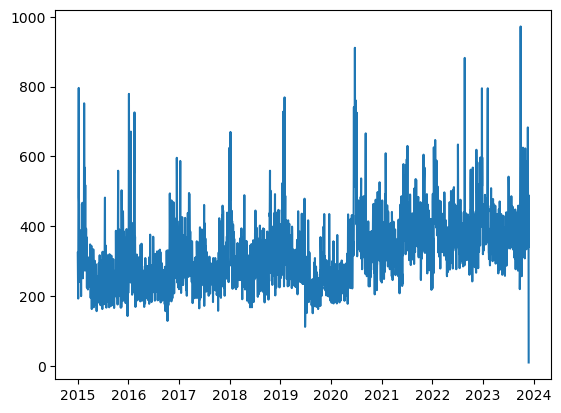

In [ ]:
days=df['created_day']
number_of_complaints=df['number_of_complaints']
plt.plot(days,number_of_complaints)

In [ ]:
#Visualization 2: What are the most common complaints in the immediate area?
#Create a visualization that shows the number of complaints by complaint type for the top 10 complaints 
#in zip code 10027 for October 1st, 2018 to September 30th, 2023 (inclusive). 

Visual_query2="""
SELECT
    complaint_type,
    COUNT(*) AS number_of_complaints
FROM
    complaint311s
WHERE
    created_date BETWEEN '2018-10-01' AND '2023-09-30'
    AND
    incident_zip='10027'
GROUP BY
    complaint_type
ORDER BY
    number_of_complaints DESC
    LIMIT 10

"""
df = pd.read_sql_query(Visual_query2, con=engine)


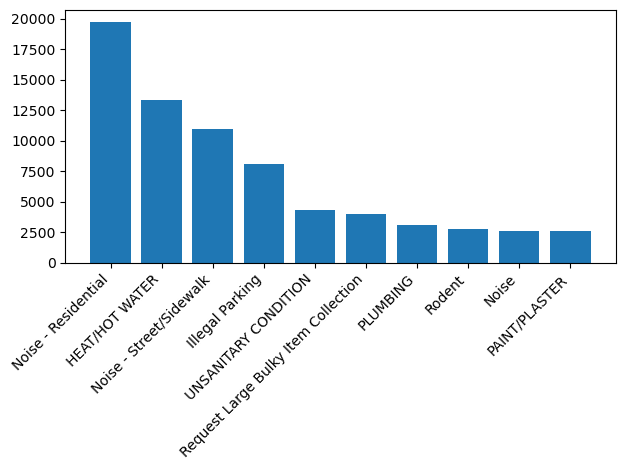

In [ ]:
complaint_type=df['complaint_type']
number_of_complaints=df['number_of_complaints']
plt.bar(complaint_type,number_of_complaints,width=0.8)
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 

In [ ]:
#Visualization 3: Is there any correlation between rent, trees, and complaints at all?
#Between January 1st, 2015 and September 30th, 2023 (inclusive), create a visualization using 2 subplots
#that share the x-axis where one subplot shows rent compared to the number of trees by zip code, and the 
#other subplot shows rent compared to the number of complaints by zip code.

#create an sql table named rent_avg_totals install the total average rent of each row in nyc_rents
Visual_query3_0="""
SELECT CAST(REGEXP_REPLACE(nyc_rents.RegionName, '\.0$', '') AS INTEGER)::VARCHAR AS regionname,rent FROM nyc_rents
ORDER BY regionname
"""
df0 = pd.read_sql_query(Visual_query3_0, con=engine)
rent_avg_total=[]
for index, row in df1.iterrows():
    rent=row['rent']
    count=0
    amount=0
    for i in range(105):
        try:
            x=float(rent[i])-int(rent[i])
            amount+=float(rent[i])
            count+=1
        except:
            count+=0
    if count!=0:
        rent_avg_total.append(amount/count)
    else:
        rent_avg_total.append(0)
        
df0['rent_avg_total']=rent_avg_total
head=['regionname','rent_avg_total']
df0=df0[head]
df0.to_sql('rent_avg_totals', con=engine, index=False, if_exists='replace')

145

In [ ]:
#This query contains average rent to the number of trees per zipcode
Visual_query3_1="""
SELECT
    rent_avg_totals.regionname,
    CASE WHEN COUNT(trees.tree_id)=0 THEN 0 ELSE AVG(rent_avg_totals.rent_avg_total)/COUNT(trees.tree_id) END AS avg_rent_to_trees
FROM
    rent_avg_totals
LEFT JOIN
    trees
ON
    trees.zipcode=rent_avg_totals.regionname

GROUP BY
rent_avg_totals.regionname

ORDER BY
rent_avg_totals.regionname
"""

#This query contains average rent to the number of complaints per zipcode
Visual_query3_2="""
SELECT
    rent_avg_totals.regionname,
    AVG(rent_avg_totals.rent_avg_total)/COUNT(complaint311s.created_date) AS avg_rent_to_complaints
    
FROM
    rent_avg_totals
JOIN
complaint311s
ON
complaint311s.incident_zip = rent_avg_totals.regionname

WHERE
complaint311s.created_date BETWEEN '2015-01-01'  AND '2023-09-30' 

GROUP BY
rent_avg_totals.regionname

ORDER BY
rent_avg_totals.regionname
"""

df1=pd.read_sql_query(Visual_query3_1, con=engine)
df2=  pd.read_sql_query(Visual_query3_2, con=engine)

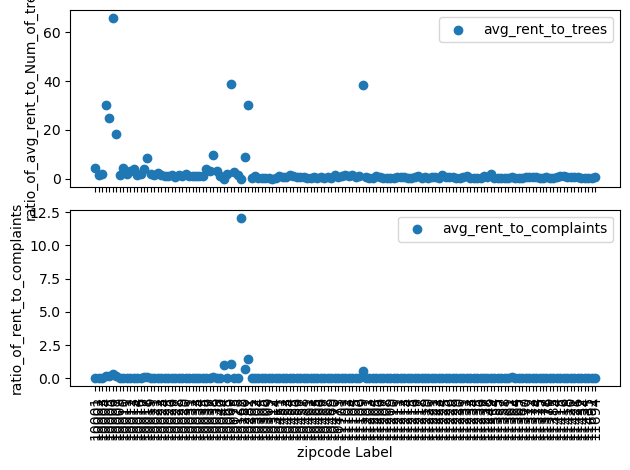

In [ ]:
x=df1['regionname']
y1=df1['avg_rent_to_trees']
y2=df2['avg_rent_to_complaints']
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.scatter(x, y1, label='avg_rent_to_trees')
ax1.set_ylabel('ratio_of_avg_rent_to_Num_of_trees')
ax1.legend()


ax2.scatter(x, y2, label='avg_rent_to_complaints')
plt.xlabel('zipcode Label') 
ax2.set_ylabel('ratio_of_rent_to_complaints')
ax2.legend()


plt.xticks(rotation='vertical') 


plt.tight_layout()

plt.show()

In [ ]:
#Visualization 4: If I can afford more in rent, will there be fewer issues & complaints?
#Create a boxplot, where the x-axis is average rent in September 2023, separated into $1000 bins 
#(i.e. $0-1000, $1001-2000, etc), and the y-axis is the number of 311 complaints observed in each 
#zip code between October 1, 2022 (inclusive) to September 30, 2023 (inclusive).


Visual_query4="""
SELECT AVG(nyc_rents.rent[104]) as avg_rent,count(complaint311s.created_date) as number_of_complaints
FROM 
    nyc_rents
JOIN
    complaint311s
ON
    complaint311s.incident_zip=CAST(REGEXP_REPLACE(nyc_rents.RegionName, '\.0$', '') AS INTEGER)::VARCHAR
WHERE
    complaint311s.created_date BETWEEN '2022-10-01'  AND '2023-09-30'
    AND
    nyc_rents.rent[104]!='NaN'
GROUP BY
    CAST(REGEXP_REPLACE(nyc_rents.RegionName, '\.0$', '') AS INTEGER)::VARCHAR
    
ORDER BY
   avg_rent

"""
df= pd.read_sql_query(Visual_query4, con=engine)

Text(0.5, 1.0, 'Average Rent compared to the number of 311 Complaints')

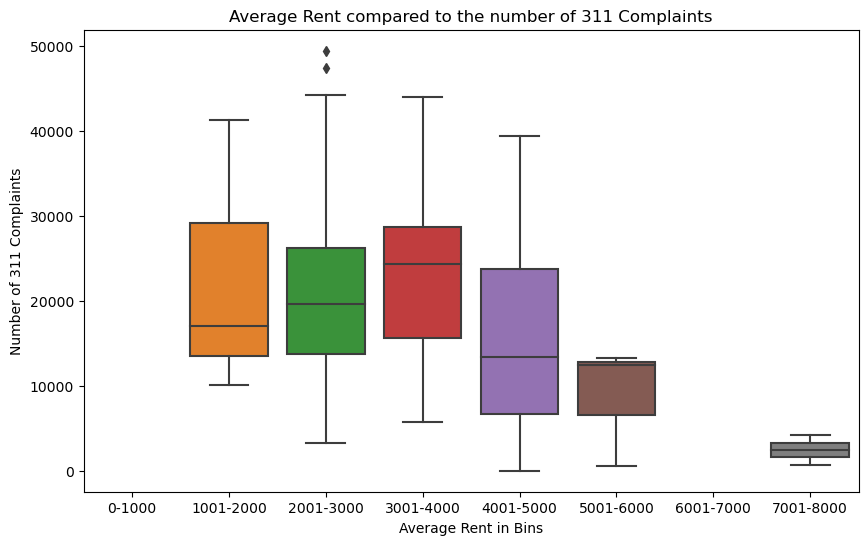

In [ ]:
bin_limit = [0, 1000, 2000, 3000, 4000, 5000, 6000,7000,8000]
bin_labels = ['0-1000', '1001-2000', '2001-3000', '3001-4000', '4001-5000', '5001-6000','6001-7000','7001-8000']
df['rent_in_bins'] = pd.cut(df['avg_rent'], bins=bin_limit, labels=bin_labels, right=False)
plt.figure(figsize=(10, 6))
sns.boxplot(x='rent_in_bins', y='number_of_complaints', data=df)
plt.xlabel('Average Rent in Bins')
plt.ylabel('Number of 311 Complaints')
plt.title('Average Rent compared to the number of 311 Complaints')

In [ ]:
#Visualization 5: Where were the recent 311 incidents reported from in the immediate area?
#Create a geospatial plot of the coordinates of reported 311 incidents that happened between January 1st, 
#2023 and September 30th, 2023 (inclusive) within a 1 kilometer radius of the same coordinate from Query 6 
#in Part 3.



campus_location = Point(-73.96253174434912, 40.80737875669467)
gdf_point = gpd.GeoDataFrame(geometry=[campus_location], crs='EPSG:4326')


buffer_radius = 1
buffered_area = gdf_point.buffer(buffer_radius)
buffered_area_wkt = buffered_area.to_wkt()[0]


Visual_query5="""
SELECT
    ST_AsText(geometry) AS coordinate_location
FROM
     complaint311s
WHERE
    ST_DWithin(
        complaint311s.geometry,
        ST_GeomFromText(:buffered_area_wkt, 4326),
        :buffer_radius * 1609.34)
AND
    complaint311s.created_date BETWEEN '2023-01-01' AND '2023-09-30'
    ;
"""

/var/folders/07/js97l93n0g56kwpk1999d4c80000gn/T/ipykernel_57158/1168741316.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_area = gdf_point.buffer(buffer_radius)


In [ ]:
#use geometry to record all the coordinate of complaints in string form
from sqlalchemy import create_engine, text 
geometry=[]
with engine.connect() as conn:
    result = conn.execute(text(Visual_query5), buffered_area_wkt=buffered_area_wkt, buffer_radius=buffer_radius)
    for row in result:
        geometry.append(row[0])
#load those elements in geometry from string to Point
geometry = [loads(wkt) for wkt in geometry]

/var/folders/07/js97l93n0g56kwpk1999d4c80000gn/T/ipykernel_57158/1734411758.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_area = gdf_point.buffer(buffer_radius)
/var/folders/07/js97l93n0g56kwpk1999d4c80000gn/T/ipykernel_57158/1734411758.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


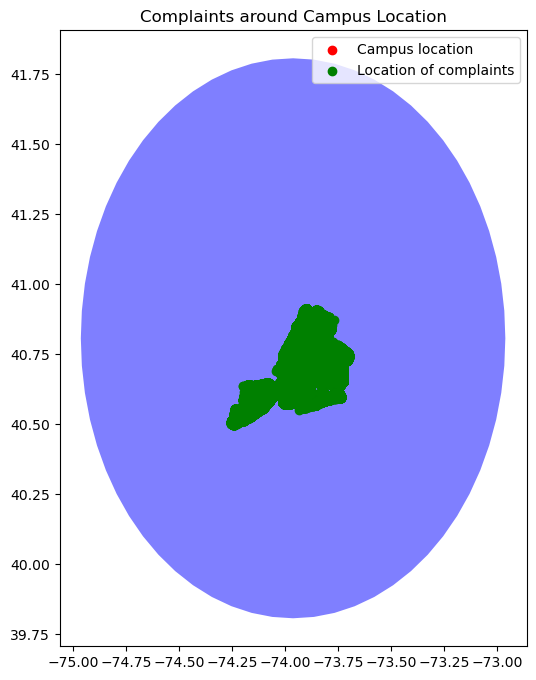

In [ ]:
complaint_311_coordinate = gpd.GeoDataFrame(geometry=geometry, crs='EPSG:4326')
campus_location = Point(-73.96253174434912, 40.80737875669467)
gdf_point = gpd.GeoDataFrame(geometry=[campus_location], crs='EPSG:4326')
buffer_radius = 1
buffered_area = gdf_point.buffer(buffer_radius)
buffered_area_wkt = buffered_area.to_wkt()[0]
fig, ax = plt.subplots(figsize=(8, 8))
gdf_point.plot(ax=ax, color='red', marker='o', label='Campus location')
buffered_area.plot(ax=ax, color='blue', alpha=0.5, label='Buffered Area')
complaint_311_coordinate.plot(ax=ax, color='green', marker='o', label='Location of complaints')
plt.title('Complaints around Campus Location')
plt.legend()



In [ ]:
#Visualization 6: Are areas trying to improve the amount of trees in the neighborhood?
#Create a geospatial plot of two sets of data: the coordinates of trees in NYC, and the coordinates of 
#"New Tree Request" 311 complaint types that were made from October 1st, 2018 to September 30th, 2023 
#(inclusive). 



# This query got all the complaints' coordinates
Visual_query6_0="""
SELECT
    ST_AsText(geometry) AS coordinate_location
FROM
     complaint311s
WHERE
    complaint311s.complaint_type= 'New Tree Request'
AND
    complaint311s.created_date BETWEEN '2018-10-01' AND '2023-09-30'
    ;
"""

# This query got all the trees' coordinates
Visual_query6_1="""
SELECT
    ST_AsText(geometry) AS coordinate_location
FROM
     trees

"""



In [ ]:
#use geometry1 to record all the coordinate of complaints in string form
geometry1=[]
with engine.connect() as conn:
    result = conn.execute(db.text(Visual_query6_0))
    for row in result:
        geometry1.append(row[0])
#load those elements in geometry1 from string to Point
geometry1 = [loads(wkt) for wkt in geometry1]

In [ ]:
#use geometry2 to record all the coordinate of complaints in string form
geometry2=[]
with engine.connect() as conn:
    result = conn.execute(db.text(Visual_query6_1))
    for row in result:
        geometry2.append(row[0])
#load those elements in geometry2 from string to Point
geometry2 = [loads(wkt) for wkt in geometry2]

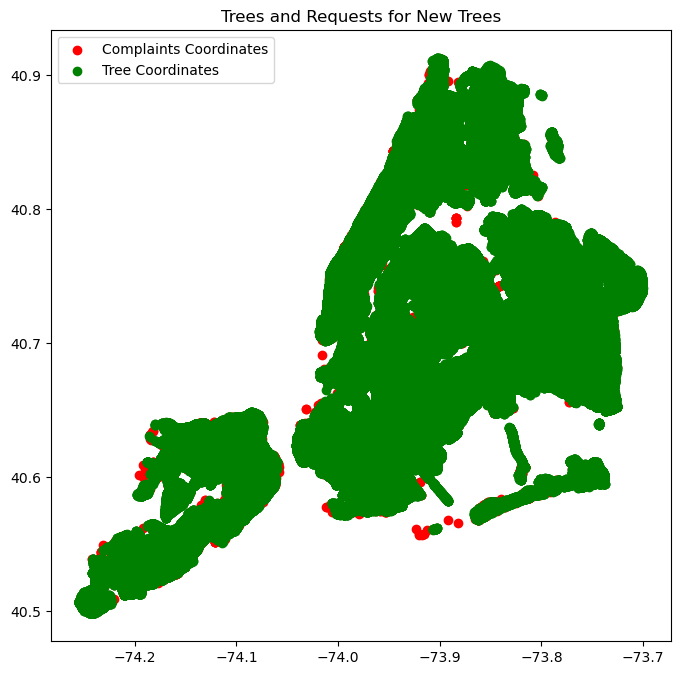

In [ ]:
complaints_coordinate=gpd.GeoDataFrame(geometry=geometry1, crs='EPSG:4326')
tree_coordinate=gpd.GeoDataFrame(geometry=geometry2, crs='EPSG:4326')
fig, ax = plt.subplots(figsize=(8, 8))
complaints_coordinate.plot(ax=ax, color='red', marker='o', label='Complaints Coordinates')
tree_coordinate.plot(ax=ax, color='green', marker='o', label='Tree Coordinates')
plt.title('Trees and Requests for New Trees')
plt.legend()